# Factor : News Coverage 

by **Subarna Chowdhury Soma** [SJSU ID: 014549587]

> * Project : Alternus Vera Iteration 1
> * Team: The Mean Squares
> * Colab 1: Factor_NewsCoverage_StoryClustering.ipynb
> * Colab 2: Factor_NewsCoverage_ScoreComputing.ipynb

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Preparation
### Imports
First some of the required packages must be imported.

### Import Library

In [0]:
import argparse
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk.sentiment

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')



/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Parameter configuration


In [0]:
#'google','vader','stanford'
runParams={'sentiment_library':   ['vader'],
           'input_file':          ['/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/all-news-kaggle/articles1.csv'],
           'output_file':         ['/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/all-news-kaggle/fakenews_by_news-coverage.csv'],
           'article_id_list':     [[120639,80103,25225,21502,57362,120636]],
           'sentiment_sentences': [5],
           'article_stats':       [False]}

# Use parameter grid even if there is only set of parameters
parameterGrid=ParameterGrid(runParams)

### Google News Data

In [0]:
''' 
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/GoogleNews-vectors-negative300.bin.gz', binary=True)
words = model.index2word

w_rank = {}
for i,word in enumerate(words):
    w_rank[word] = i

WORDS = w_rank
'''


" \nmodel = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/GoogleNews-vectors-negative300.bin.gz', binary=True)\nwords = model.index2word\n\nw_rank = {}\nfor i,word in enumerate(words):\n    w_rank[word] = i\n\nWORDS = w_rank\n"

### Cleaning Input Data

This is the same function as used in Part One.

In [0]:
def getInputDataAndDisplayStats(filename,processDate,printSummary=False):

	df=pd.read_csv(filename)

	df=df.drop_duplicates('content')
	df=df[~df['content'].isnull()]

	
	df=df[df['content'].str.len()>=200]

	# Find and remove summary NYT "briefing" articles to avoid confusing the clustering
	targetString="(Want to get this briefing by email?"
	df['NYT summary']=df['content'].map(lambda d: d[:len(targetString)]==targetString)
	df=df[df['NYT summary']==False]

	# The following removes a warning that appears in many of the Atlantic articles.
	# Since it is commonly at the beginning, it brings a lot of noise to the search for similar articles
	# And subsequently to the assessment of sentiment
	targetString="For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below"
	df['content']=df['content'].str.replace(targetString,'')

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# More Atlantic-specific removals (for daily summaries with multiple stories contained)
	df=df[df['content'].str.contains("To sign up, please enter your email address in the field")==False]

	# Remove daily CNN summary
	targetString="CNN Student News"
	df=df[df['content'].str.contains(targetString)==False]

	if printSummary:
		print("\nArticle counts by publisher:")
		print(df['publication'].value_counts())

		print("\nArticle counts by date:")
		print(df['date'].value_counts())
		

	if processDate!=None:
		df=df[df['date']==processDate]
	df.reset_index(inplace=True, drop=True)

	# Remove non-ASCII characters
	df['processed_content']=df['content'].map(lambda x: removeNonASCIICharacters(x))
	df['score'] = 0.0

	print("\nFinal dataset:\n\nDate:",processDate,"\n")
	print(df['publication'].value_counts())

	return df

##########################################################################################

def removeNonASCIICharacters(textString): 
    return "".join(i for i in textString if ord(i)<128)

### Load the articles from the corpus


In [0]:
articleDataFrame=getInputDataAndDisplayStats(runParams['input_file'][0],None,False)


Final dataset:

Date: None 

Breitbart           23585
CNN                 11249
New York Times       7620
Business Insider     6504
Atlantic              157
Name: publication, dtype: int64


In [0]:
articleDataFrame.date.unique

<bound method Series.unique of 0        2016-12-31
1        2017-06-19
2        2017-01-06
3        2017-04-10
4        2017-01-02
            ...    
49110    2017-01-11
49111    2017-01-11
49112    2017-01-11
49113    2017-01-11
49114    2017-01-11
Name: date, Length: 49115, dtype: object>

In [0]:
articleDataFrame.shape

(49115, 13)

In [0]:
col_id_list = articleDataFrame['id'].tolist()
#col_id_list 


### Take All Columns

In [0]:
 articleDataFrame['id'].count()


49115

Comment this line if not want to take all the IDs

In [0]:
runParams['article_id_list'][0] = col_id_list 

## News Coverage computation methods


In [0]:
class SentimentAnalyser():

	scaleMin=-1.
	scaleMax=1.

    # Initializer / Instance attributes
	def __init__(self, library):
		if library=='vader':
			self.analyser=NLTKVaderSentimentAnalyser()
		else:
			print("ERROR - NO RECOGNISED LIBRARY")

	def getOverallArticleScore(self,articleResults):

		
		numSentences=0.
		totalSentScore=0.
		for sentence in articleResults:
			numSentences+=1
			totalSentScore+=self.analyser.getSentenceScoreFromResults(sentence)

		value=(totalSentScore/numSentences-self.analyser.scaleMin)/(self.analyser.scaleMax-self.analyser.scaleMin)
		return self.scaleMin+value*(self.scaleMax-self.scaleMin)

	def generateResults(self,textToAnalyse):
		return self.analyser.generateResults(textToAnalyse)

### Vader library class


In [0]:
class NLTKVaderSentimentAnalyser():
 

	scaleMin=-1.
	scaleMax=1.

	def __init__(self):
		self.nltkVaderAnalyser=SentimentIntensityAnalyzer()
		return

	def generateResults(self,textToAnalyse):
		ss=[]
		for sentence in nl.sent_tokenize(textToAnalyse):
			ss.append(self.nltkVaderAnalyser.polarity_scores(sentence))
		return ss

	def getSentenceScoreFromResults(self,sentenceResults):
		return sentenceResults['compound']

### Computing Balance Score

In [0]:
def computePopulationBalanceScore(articleScoreDict,sentimentClass):
	population=[-1.+(x-sentimentClass.scaleMin)/(sentimentClass.scaleMax-sentimentClass.scaleMin)*(1.-(-1.)) for x in articleScoreDict.values()]
	return statistics.pstdev(population)



### Overall- Avg Score Computation for Story

In [0]:
def computePopulationBalanceScoreHistoMean(articleScoreDict,sentimentClass):

	numBuckets=len(articleScoreDict)
	articleValues=pd.Series(articleScoreDict)
	

	articleValues=articleValues/0.86

	populatedBuckets=0
	for i in range(numBuckets):
		bucketFrom=sentimentClass.scaleMin+i*(sentimentClass.scaleMax-sentimentClass.scaleMin)/numBuckets
		bucketTo=bucketFrom+(sentimentClass.scaleMax-sentimentClass.scaleMin)/numBuckets

		if bucketTo==sentimentClass.scaleMax:
			bucketTo+=0.001
		numSamples=((bucketFrom<=articleValues) & (articleValues<bucketTo)).sum()
		if numSamples>0:
			populatedBuckets+=1


	return (populatedBuckets/numBuckets * (1.-abs(articleValues.mean())))

### NC-Score: News Source Credibility 

In [0]:
def cleaning(raw_news):
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [0]:
'''
def words(text): return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))
'''

In [0]:
def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

In [0]:
def word_spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    correct_number  = 0
    incorrect_number = 0
    print(text)
    for i in range(len(all_words)):
        if correction(all_words[i]) == all_words[i]:
            correct_number = correct_number + 1
        else:
            incorrect_number = incorrect_number + 1
    return correct_number , incorrect_number

In [0]:
def credibility(row):
  correct, incorrect = word_spell_checker(row['processed_title'])
  if ((correct + incorrect) == 0):
    value = correct
    print('correct',correct)
    print('incorrect',incorrect)
  else: 
    value = correct/(correct + incorrect)
  return value

In [0]:
def computeCredibilityScore(articleDataFrame): 
    t1 = time.time()
    articleDataFrame['processed_title'] = articleDataFrame["title"].apply(cleaning) 
    t2 = time.time()
    print("\nProcessed title: \n", len(articleDataFrame), "news:", (t2-t1)/60, "min")

    vector = CountVectorizer()
    vector.fit(articleDataFrame['processed_content'])
    countVect = vector.transform(articleDataFrame['processed_content'])
    print(vector)

    countVect.toarray()

    articleDataFrame['credibility_score'] = articleDataFrame.apply (lambda row: credibility(row), axis=1)

 Commenting this computation for now, colab is crashing due to data load. So using other factors

In [0]:
#computeCredibilityScore(articleDataFrame)

## Story map loading


In [0]:
def setupStoryMapAndReportList(args=None,reportArticleList=None,storyMapFileName=None):

	if args==None:
		articleList=reportArticleList
		fileName=storyMapFileName
	else:
		articleList=args['article_id_list']
		fileName=args['story_map_validation']

	reportArticleList=articleList
	if fileName!=None:
		storyMap=readStoryMapFromFile(fileName)
		if reportArticleList==None:
			reportArticleList=[]
			for story, articleList in storyMap.items():
				reportArticleList.append(articleList[0])
	else:
		storyMap=None
	return storyMap,reportArticleList

def readStoryMapFromFile(filename):
	return readDictFromCsvFile(filename,'StoryMap')

##########################################################################################

def readGridParameterRangeFromFile(filename):
	return readDictFromCsvFile(filename,'GridParameters')

##########################################################################################

def readDictFromCsvFile(filename,schema):
	gridParamDict={}
	with open(filename, 'r') as f:
		for row in f:
			row=row[:-1] # Exclude the carriage return
			row=row.split(",")
			key=row[0]
			vals=row[1:]
			
			if schema=='GridParameters':
				if key in ['story_threshold','tfidf_maxdf']:
					finalVals=list(float(n) for n in vals)
				elif key in ['ngram_max','tfidf_mindf','max_length']:
					finalVals=list(int(n) for n in vals)
				elif key in ['lemma_conversion','tfidf_binary']:
					finalVals=list(str2bool(n) for n in vals)
				elif key in ['parts_of_speech']:
					listlist=[]
					for v in vals:
						listlist.append(v.split("+"))
					finalVals=listlist
				elif key in ['tfidf_norm','nlp_library']:
					finalVals=vals
				else:
					print(key)
					print("KEY ERROR")
					return
			elif schema=='StoryMap':
				finalVals=list(int(n) for n in vals)
			else:
				print(schema)
				print("SCHEMA ERROR")
				return
			
			gridParamDict[key]=finalVals
	return gridParamDict

### Load the story map from file

In [0]:
storyMap,reportArticleList=setupStoryMapAndReportList(storyMapFileName='/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/all-news-kaggle/storyMapForValidation1.csv')

In [0]:
storyMap,reportArticleList=setupStoryMapAndReportList(None,None,None)

In [0]:
if storyMap is None:
  print('')
else:
  for story, articleList in storyMap.items():
    print(story,":",articleList)

### Story map with user requested specific article list


In [0]:
def collapseRequestedArticleListIntoStoryList(requestedArticleList,storyMap):

	if storyMap==None:
		newStoryMap={}
	else:
		newStoryMap=storyMap.copy()

	found=False
	for story,articleListFromMap in newStoryMap.items():
		if len(articleListFromMap)==len(requestedArticleList):
			y=sum([x in articleListFromMap for x in requestedArticleList])
			if y==len(articleListFromMap):
				found=True
                

	if not found:
		newStoryMap[requestedArticleList[0]]=requestedArticleList
	print('newStoryMap',newStoryMap)
	return newStoryMap

## Main Process Run


In [0]:
for i,currentParams in enumerate(parameterGrid):
  if len(parameterGrid)>1:
    print("Combination:",i+1,"of",len(parameterGrid))
    print(currentParams)

  iterationStoryMap=collapseRequestedArticleListIntoStoryList(currentParams['article_id_list'],storyMap)
  sentimentAnalyser=SentimentAnalyser(currentParams['sentiment_library'])

  for story,articleList in iterationStoryMap.items():
    articleSentScores={}
    print("ANALYSING STORY:",story,"using",currentParams['sentiment_library'])
    print("Number of articles in story:",len(articleList))

    for article in articleList:
      articleContent=articleDataFrame[articleDataFrame['id']==article].iloc[0]['content']
      if currentParams['sentiment_sentences']!=None:
	      articleSentences=nl.sent_tokenize(articleContent)
	      textToAnalyse=' '.join(articleSentences[:currentParams['sentiment_sentences']])	
      else:
	      textToAnalyse=articleContent

      results=sentimentAnalyser.generateResults(textToAnalyse)
      articleSentScores[article]=sentimentAnalyser.getOverallArticleScore(results)
    
    # Sort and display results
    sortedArticleSentScores=sorted(articleSentScores.items(), key=operator.itemgetter(1))
    print("\nArticle sentiments, most positive first:")
    for article in reversed(sortedArticleSentScores):
	      print(article[0],":", round(article[1],3),articleDataFrame[articleDataFrame['id']==article[0]].iloc[0]['publication'])
	      articleDataFrame.at[articleDataFrame[articleDataFrame['id']==article[0]].index[0],'score'] = round(article[1],3)
    

    print("\nNEWS COVERAGE SCORE:",round(computePopulationBalanceScoreHistoMean(articleSentScores,SentimentAnalyser),3),"\n")


Streaming output truncated to the last 5000 lines.
49378 : -0.366 Breitbart
64116 : -0.366 CNN
21042 : -0.366 New York Times
56160 : -0.366 CNN
40854 : -0.366 Breitbart
44283 : -0.366 Breitbart
43590 : -0.366 Breitbart
53534 : -0.366 CNN
56400 : -0.366 CNN
27073 : -0.366 Breitbart
34280 : -0.367 Breitbart
72201 : -0.367 Business Insider
39758 : -0.367 Breitbart
62443 : -0.367 CNN
62955 : -0.367 CNN
38587 : -0.367 Breitbart
64457 : -0.367 CNN
48792 : -0.367 Breitbart
58999 : -0.367 CNN
21600 : -0.367 New York Times
42977 : -0.367 Breitbart
47069 : -0.367 Breitbart
33149 : -0.367 Breitbart
71611 : -0.367 Business Insider
48435 : -0.367 Breitbart
60489 : -0.367 CNN
33573 : -0.367 Breitbart
31700 : -0.367 Breitbart
28630 : -0.367 Breitbart
17356 : -0.367 New York Times
33263 : -0.367 Breitbart
47744 : -0.367 Breitbart
21251 : -0.367 New York Times
46240 : -0.367 Breitbart
34798 : -0.367 Breitbart
31846 : -0.367 Breitbart
56991 : -0.367 CNN
41672 : -0.367 Breitbart
21583 : -0.367 New York T

## Output inspection


In [0]:
articleDataFrame[articleDataFrame['id']==80103]#['content'].values[0]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,NYT summary,processed_content,score


## Fakeness Label from News Coverage Score

* positive sentiment: ``compound`` score >= 0.05 
* neutral sentiment: (``compound`` score > -0.05) and (``compound`` score < 0.05) 
* negative sentiment: ``compound`` score <= -0.05 

### Using Sentiment

###param try1

In [0]:
articleDataFrame.loc[articleDataFrame.score >= 0.05, 'label_NewsCoverage'] = 1 # true news
articleDataFrame.loc[((articleDataFrame.score > -0.05) & (articleDataFrame.score < 0.05 )), 'label_NewsCoverage'] = 2 # avg
articleDataFrame.loc[articleDataFrame.score <= -0.05, 'label_NewsCoverage'] = 0 # fake news


###param try2

In [0]:
articleDataFrame.loc[articleDataFrame.score >= 0.00, 'label_NewsCoverage'] = 1 # true news
#articleDataFrame.loc[((articleDataFrame.score > -0.05) & (articleDataFrame.score < 0.05 )), 'label_NewsCoverage'] = 2 # avg
articleDataFrame.loc[articleDataFrame.score < 0.00, 'label_NewsCoverage'] = 0 # fake news

Size of the Labels column
label_NewsCoverage
0.0    23837
1.0    25278
dtype: int64


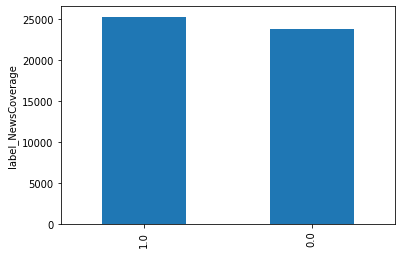

In [0]:
print("Size of the Labels column")
print(articleDataFrame.groupby('label_NewsCoverage').size())
articleDataFrame['label_NewsCoverage'].value_counts().plot(kind="bar")
plt.ylabel('label_NewsCoverage')
plt.show()

In [0]:
articleDataFrame[articleDataFrame.id.isin([120639, 80103, 25225, 21502, 57362, 120636])]

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,NYT summary,processed_content,score,label_NewsCoverage
3717,3799,21502,All Impeachments Are Political. But Was Brazil...,New York Times,Amanda Taub,2016-09-01,2016.0,9.0,NaN,WASHINGTON — Was the impeachment of Dilma R...,False,WASHINGTON Was the impeachment of Dilma Ro...,-0.153,0.0
6669,6830,25225,Dilma Rousseff Is Ousted as Brazil’s President...,New York Times,Simon Romero,2016-09-01,2016.0,9.0,NaN,BRASÍLIA — The Senate on Wednesday impeache...,False,BRASLIA The Senate on Wednesday impeached ...,-0.049,0.0
36985,38514,57362,Dilma Rousseff is out. Now what?,CNN,NaN,2016-09-01,2016.0,9.0,NaN,(CNN) Brazil’s problems cannot be solved mere...,False,(CNN) Brazils problems cannot be solved merel...,-0.291,0.0


### Using Credibility

In [0]:
def computeLabelCredibility(articleDataFrame):
    articleDataFrame.loc[articleDataFrame.credibility_score >= 0.80, 'label_credibility'] = 1 # true news
    articleDataFrame.loc[articleDataFrame.credibility_score < 0.80, 'label_credibility'] = 0 # fake news

    print("Size of the label_credibility column")
    print(articleDataFrame.groupby('label_credibility').size())
    articleDataFrame['label_credibility'].value_counts().plot(kind="bar")
    plt.ylabel('label_credibility')
    plt.show()

Commenting this computation for now, colab is crashing due to data load. So using other factors

In [0]:
#computeLabelCredibility(articleDataFrame)

## Classification

### Prepare Test and Training Data 

In [0]:

def get_words( headlines ):               
    headlines_onlyletters = re.sub("[^a-zA-Z]", " ",headlines) #Remove everything other than letters     
    words = headlines_onlyletters.lower().split() #Convert to lower case, split into individual words    
    stops = set(stopwords.words("english"))  #Convert the stopwords to a set for improvised performance                 
    meaningful_words = [w for w in words if not w in stops]   #Removing stopwords
    return( " ".join( meaningful_words )) #Joining the words

In [0]:
articleDataFrame['label_NewsCoverage'] = articleDataFrame['label_NewsCoverage'].astype('int')

In [0]:
def prepareTestTraining(x_col, y_col, articleDataFrame):
  #articleDataFrame['label_NewsCoverage'] = articleDataFrame['x_col'].astype('int')

  # Separate the dataframe for input(X) and output variables(y)
  #['Unnamed: 0', 'id', 'title', 'publication', 'author', 'date', 'year','month', 'url', 'content', 'NYT summary', 'processed_content','score', 'label_NewsCoverage']
  X = articleDataFrame[x_col]
  Y = articleDataFrame[y_col]

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)
  X_train = np.array(X_train);
  X_test = np.array(X_test);
  Y_train = np.array(Y_train);
  Y_test = np.array(Y_test);
  cleanHeadlines_train = [] #To append processed headlines
  cleanHeadlines_test = [] #To append processed headlines
  number_reviews_train = len(X_train) #Calculating the number of reviews
  number_reviews_test = len(X_test) #Calculating the number of reviews

  for i in range(0,number_reviews_train):
    cleanHeadline = get_words(X_train[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_train.append( cleanHeadline )
  for i in range(0,number_reviews_test):
    cleanHeadline = get_words(X_test[i]) #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadlines_test.append( cleanHeadline )

  #vectorize = CountVectorizer(stop_words='english')
  vectorize = CountVectorizer(analyzer = "word",max_features = 1700)    #(stop_words='english')
  bagOfWords_train = vectorize.fit_transform(cleanHeadlines_train)
  X_train = bagOfWords_train.toarray()
  bagOfWords_test = vectorize.transform(cleanHeadlines_test)
  X_test = bagOfWords_test.toarray()

  #call autoML
  callAutoML(X_train,Y_train,X_test,Y_test)

### Auto ML

In [0]:
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
#models.append(('KNN' , KNeighborsClassifier()))
#models.append(('CART' , DecisionTreeClassifier()))
#models.append(('NB' , GaussianNB()))
#models.append(('SVM' , SVC()))
models.append(('MNB', MultinomialNB()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [0]:
def callAutoML(X_train,Y_train,X_test,Y_test):
  results = []
  names = []

  '''
  for name, model in models:
      kfold = KFold(n_splits=num_folds, random_state=42)
      cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results)
      names.append(name)
      msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
      print(msg) '''

  for name, model in models:
      clf = model
      clf.fit(X_train, Y_train)
      Y_pred = clf.predict(X_test)
      accu_score = accuracy_score(Y_test, Y_pred)
      print(name + ": " + str(accu_score))

In [0]:
prepareTestTraining('processed_content','label_NewsCoverage',articleDataFrame)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR: 0.7206650831353919
LDA: 0.7063454360366475
MNB: 0.6915507295554801
RF: 0.7026806922293858


## Save to CSV

In [0]:
#articleDataFrame.to_csv (runParams['output_file'][0], index = False, header=True)

# Description and Insight



## News Coverage

* This factor investigates news coverage of the same story in different media outlets. Later this factor classified model will be used to measure fakeness in data. 

## Data Narrative

* In this colab I have implement the different computation methods using different metrics and techniques to compute news coverage. This data has news from different popular media outlets from years of 2016 and July 2017
* This dataset has 50k rows and 13 columns including news with published and publishing timestamp. To clarify some terms:
>> * ARTICLE - a single article printed by one news publication
>> * STORY - the underlying event that an article is in reference to
 


## Pre-processing

* Preprocessing and data clean up is done using NLTK to perform following NLP preprocessing on data. 
 
>> * Removing stopwords
>> * Remove special character
>> * Remove punctuations
>> * Lowercase 
>> * Stemming 
>> * Lemmatization
>> * Removing junk and "briefing" articles
>> * Removing Daily Summary articles
>> * Removing non-ASCII characters
>> * Parts-of-speech filtering 

## Implementation Details
 
* In the first colab First story clusters have been determined. The individual articles within each story are analyzed to measure neutrality. For this, I have used Vadar library to get a sentiment score. Sentiment is aggregated to compute the coverage of the story also.  
 
* Next metric is measuring the 'balance' of coverage. It is done by identifying the top point of views( key words). Each point on the sentiment scale represents a distinct point of view. 
 
* These two terms are then averaged to measure how well balanced
the overall coverage of the story is. A perfect score for the aggregate coverage of a story is 1.
 
* As this data set is unlabelled, so I have to label this data to implement classification model. I have a threshold to identify 'good/bad' [1/0] coverage based on news coverage score. This value is stored in 'label_NewsCoverage' column. I have fine tuned the threshold multiple times. 
 
* Finally I have used autoML to try different classification algorithms to compare accuracy. The Logistic Regression Model has performed well with 75% accuracy. Here are the rest of the results: 

Factor | Algorithm | Accuracy
--- | --- | -----
News Coverage | Logistic Regression  | 75%
News Coverage | Linear Discriminant Analysis​(LDA) | 72%
News Coverage | Multinomial Bayes | 70%
News Coverage | Random Forest  | 72%

 
* **Future Work and Challenges** : 
 To compare and compute news coverage I have thought of some other terms also,ig. biasness, readability, Dale-Chall Readability Test, credibility. In fact I have implemented credibility also in this colab. But I could not include this score because the colab is crashing for 50K data with all these computations.  So as a part of an upcoming task, I would like to implement some of these features to measure news coverage from different perspectives with better classification accuracy. 
 



# Reference

1. https://towardsdatascience.com/machine-learning-versus-the-news-3b5b479d8e6a
2. https://www.kaggle.com/arjunchandrasekhara/news-classification
3. https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
4. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
5. https://github.com/javedsha/text-classification
6. https://github.com/sharma-vidhi/Fake-News-Detection
7. https://www.kaggle.com/thebrownviking20/k-means-clustering-of-1-million-headlines